<center><a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/05 Deep Learning/notebooks/12-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></center>

# Deep Convolutional GAN

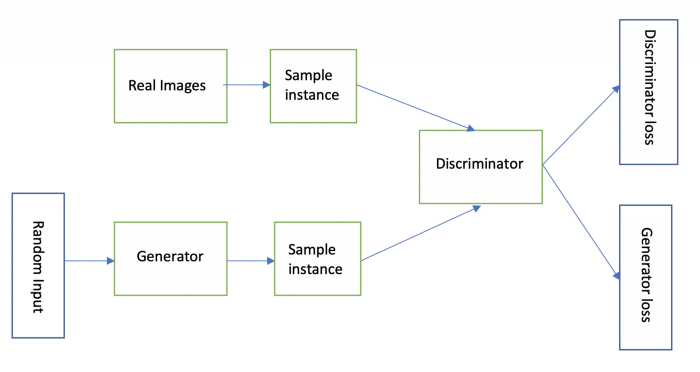

En este ejemplo entrenaremos una GAN en el corpus MNIST

In [1]:
import tensorflow as tf

In [3]:
from tensorflow.keras.datasets.mnist import load_data
from numpy import expand_dims

(X_train, _), (_, _) = load_data()
print(X_train.shape)

# ----- Añadimos una dimensión para el canal de la imágen 
X = expand_dims(X_train, axis=-1)
print(X.shape)

# ----- Preparamos los datos y escalamos
X = X.astype('float32')
X = X / 255.0

(60000, 28, 28)
(60000, 28, 28, 1)


## Generador

Definimos el generador. 

* Observa la capa `Conv2DTranspose`, esta capa realiza lo opuesto a una capa de convolución, suele llamarse *deconvolución*. De acuerdo a la [documentación](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/):

    *The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.*

* Por otro lado, observa la capa de salida, ¿qué forma tiene? ¿qué activación tiene?
* Finalmente, observa que este modelo no se compila.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

latent_dim = 100

g_model = Sequential(name="generador")
# foundation for 7x7 image
n_nodes = 128 * 7 * 7
g_model.add(Dense(n_nodes, input_dim=latent_dim))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(Reshape((7, 7, 128)))
# upsample to 14x14
g_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
g_model.add(LeakyReLU(alpha=0.2))

g_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

g_model.summary()

Model: "generador"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

Ya podemos generar imágenes, aún sin haber entrenado el modelo.

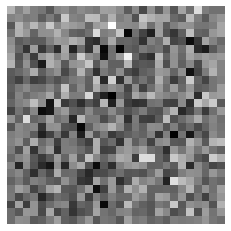

In [5]:
import matplotlib.pyplot as plt

noise = tf.random.normal([1, latent_dim])
generated_image = g_model.predict(noise)

# ----- También podemos pasar el ruido a través de la red con el método 'call':
# generated_image = g_model(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

In [6]:
generated_image.shape

(1, 28, 28, 1)

## Discriminador

Definimos la red discriminadora, esta es una red CNN para clasificación binaria.

In [9]:
from tensorflow.keras.optimizers import Adam

d_model = Sequential(name='discriminador')
d_model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
d_model.add(LeakyReLU(alpha=0.2))
d_model.add(Dropout(0.4))
d_model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
d_model.add(LeakyReLU(alpha=0.2))
d_model.add(Dropout(0.4))
d_model.add(Flatten())
d_model.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.0002, beta_1=0.5)
d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

d_model.summary()

Model: "discriminador"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 3136)            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Utilizamos el discriminador (aún no entrenado) para clasificar las imágenes generadas como reales o falsas. El modelo será entrenado para dar valores positivos a las imágenes reales y negativos a las falsas.

In [10]:
decision = d_model.predict(generated_image)
print(decision)

[[0.47684002]]


## Definimos el modelo GAN completo

In [11]:
# make weights in the discriminator not trainable
d_model.trainable = False
# connect them
gan_model = Sequential(name="GAN")
# --- generador ---
gan_model.add(g_model)
# --- discriminador ---
gan_model.add(d_model)

optimizador = Adam(lr=0.0002, beta_1=0.5)
gan_model.compile(loss='binary_crossentropy', optimizer=optimizador)

gan_model.summary(show_trainable=True)

Model: "GAN"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 generador (Sequential)      (None, 28, 28, 1)         1164289   Y          
                                                                            
 discriminador (Sequential)  (None, 1)                 40705     N          
                                                                            
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
____________________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Entrenamiento

Dada la arquitectura del modelo, no podemos usar el método `fit` directamente para entrenar el modelo GAN. Definimos nuestro propio entrenamiento

In [21]:
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
import matplotlib.pyplot as plt

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=256):
    batches_per_epoch = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        for j in range(batches_per_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real,X_fake)), vstack((y_real,y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch,1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan) 
            print('epoch: %d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batches_per_epoch, d_loss, g_loss))
        if (i+1)%2 == 0:
            X_fake, y_fake = generate_fake_samples(g_model,latent_dim,100)
            plot_n_save(X_fake,i+1)
    summarize_performance(g_model, d_model, dataset, latent_dim)

   
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n_samples fake examples, along with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	y = zeros((n_samples, 1))
	return X, y

# select a random collection of n_samples real images, along with class labels
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y

# create and save a plot of generated images
def plot_n_save(examples, epoch, n=10):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	filename = 'generated_plot_e%03d.png' % (epoch)
	plt.savefig(filename)
	plt.close()

# evaluate the discriminator model on the fake images and real images
def summarize_performance(g_model, d_model, dataset, latent_dim, n_samples=100):
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

Entrenamos el modelo

In [20]:
train(g_model, d_model, gan_model, X, latent_dim, n_epochs=10)

epoch: 1, 1/234, d=0.691, g=0.718
epoch: 1, 2/234, d=0.679, g=0.708
epoch: 1, 3/234, d=0.685, g=0.703
epoch: 1, 4/234, d=0.687, g=0.688
epoch: 1, 5/234, d=0.684, g=0.705
epoch: 1, 6/234, d=0.680, g=0.718
epoch: 1, 7/234, d=0.678, g=0.725
epoch: 1, 8/234, d=0.682, g=0.739
epoch: 1, 9/234, d=0.692, g=0.721
epoch: 1, 10/234, d=0.688, g=0.717
epoch: 1, 11/234, d=0.685, g=0.721
epoch: 1, 12/234, d=0.677, g=0.735
epoch: 1, 13/234, d=0.680, g=0.748
epoch: 1, 14/234, d=0.679, g=0.744
epoch: 1, 15/234, d=0.678, g=0.745
epoch: 1, 16/234, d=0.673, g=0.742
epoch: 1, 17/234, d=0.679, g=0.755
epoch: 1, 18/234, d=0.672, g=0.764
epoch: 1, 19/234, d=0.676, g=0.744
epoch: 1, 20/234, d=0.685, g=0.713
epoch: 1, 21/234, d=0.671, g=0.716
epoch: 1, 22/234, d=0.682, g=0.690
epoch: 1, 23/234, d=0.665, g=0.714
epoch: 1, 24/234, d=0.685, g=0.706
epoch: 1, 25/234, d=0.679, g=0.711
epoch: 1, 26/234, d=0.666, g=0.726
epoch: 1, 27/234, d=0.672, g=0.726
epoch: 1, 28/234, d=0.685, g=0.716
epoch: 1, 29/234, d=0.679, g=